In [57]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np


In [58]:


def load_json_directory(directory_path="."):
    aggregated_data = {}
    x_label = None
    # List all files in the directory
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(".json"):
            file_path = os.path.join(directory_path, filename)

            # Read the JSON file
            with open(file_path, "r") as f:
                try:
                    data = json.load(f)
                except json.JSONDecodeError as e:
                    print(f"Skipping malformed JSON file: {filename} ({e})")
                    continue
            
            # Use filename without extension as dictionary key
            key = os.path.splitext(filename)[0]
            aggregated_data[key] = data

            if x_label == None:
                x_label = list(data.keys())

    return aggregated_data, x_label


if __name__ == "__main__":
    result, x_label = load_json_directory(".")
    print(json.dumps(result, indent=4))


{
    "Aberavon_timings": {
        "load_image": 1.0372599000111222,
        "cloud_mask_create": 1.0303261000663042,
        "cloud_mask_apply": 0.5899736999999732,
        "marchingsquares_preprocess": 1.6584806999890134,
        "marchingsquares_otsu_segmentation": 1.1286223001079634,
        "marchingsquares_point_array": 0.00011339993216097355,
        "marchingsquares_list_vectors": 27.76538699993398,
        "marchingsquares_vector_shapes": 96.02634850004688,
        "chain_encode": 0.820932500064373
    },
    "Balivanich, South Uist_timings": {
        "load_image": 1.0523045000154525,
        "cloud_mask_create": 0.9362293999874964,
        "cloud_mask_apply": 0.37794799997936934,
        "marchingsquares_preprocess": 1.2545813999604434,
        "marchingsquares_otsu_segmentation": 1.2162243999773636,
        "marchingsquares_point_array": 9.320001117885113e-05,
        "marchingsquares_list_vectors": 26.75701850000769,
        "marchingsquares_vector_shapes": 2262.326461500

In [59]:
print(x_label)

['load_image', 'cloud_mask_create', 'cloud_mask_apply', 'marchingsquares_preprocess', 'marchingsquares_otsu_segmentation', 'marchingsquares_point_array', 'marchingsquares_list_vectors', 'marchingsquares_vector_shapes', 'chain_encode']


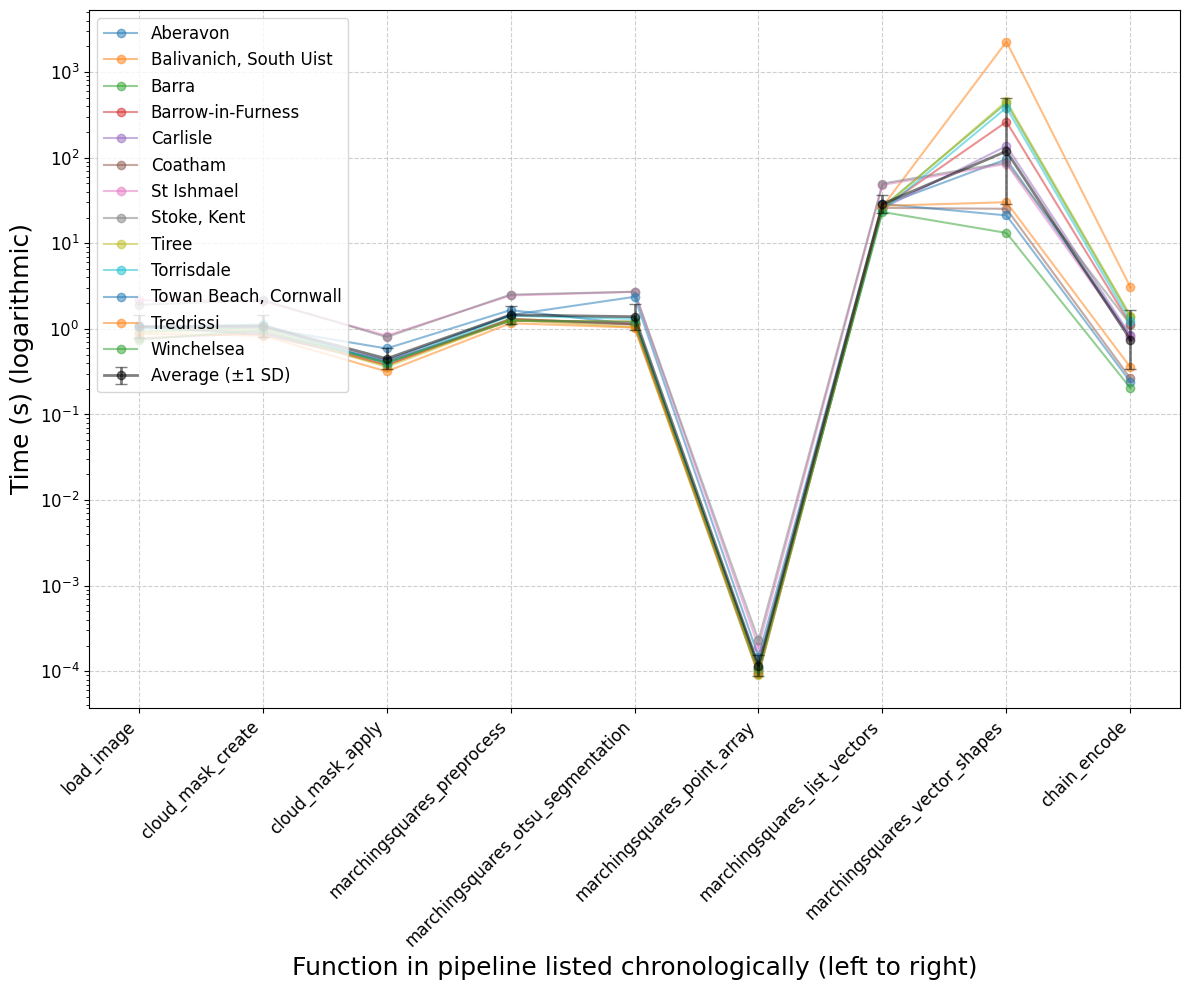

In [60]:
import numpy as np
import matplotlib.pyplot as plt

all_values = []
for file, data in result.items():
    values = [data[key] for key in x_label]
    all_values.append(values)

all_values = np.array(all_values)

log_values = np.log(all_values)   
mean_log = np.mean(log_values, axis=0)
std_log  = np.std(log_values, axis=0)

mean_vals = np.exp(mean_log)
lower = np.exp(mean_log - std_log)
upper = np.exp(mean_log + std_log)

plt.figure(figsize=(12, 10))
colours = plt.get_cmap("tab10")
# Plot each image’s timings
for i, (file, values) in enumerate(zip(result.keys(), all_values)):
    location = file.split("_timings",1)[0]
    plt.plot(values, marker="o", alpha=0.5, label=location, color=colours(i % 10))



# Plot mean with error bars
plt.errorbar(
    range(len(x_label)),
    mean_vals,
    yerr=[mean_vals - lower, upper - mean_vals],
    fmt='-o',
    color='black',
    linewidth=2,
    capsize=4,
    label='Average (±1 SD)',
    alpha = 0.5
)


plt.xticks(range(len(x_label)), x_label, rotation=45, ha = "right",fontsize = 12)
plt.yscale("log")
plt.xlabel("Function in pipeline listed chronologically (left to right)",fontsize = 18)
plt.ylabel("Time (s) (logarithmic)",fontsize = 18)
plt.yticks(fontsize = 12)
plt.legend(loc = "upper left", fontsize = 12)

plt.grid(True, which="major", linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

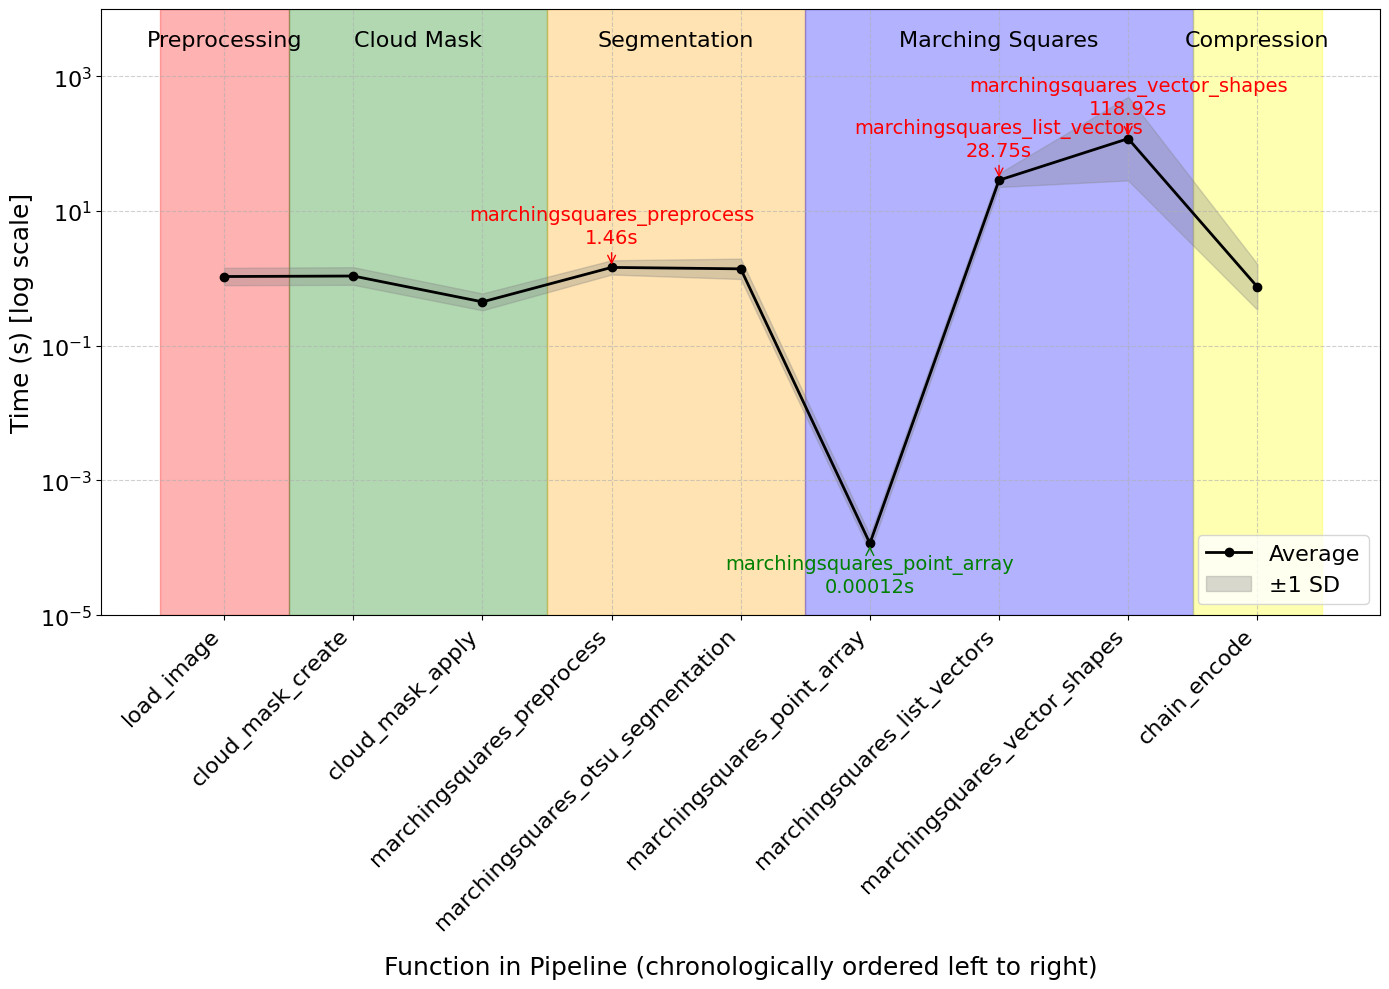

In [61]:
import numpy as np
import matplotlib.pyplot as plt


all_values = []
for file, data in result.items():
    values = [data[key] for key in x_label]
    all_values.append(values)

all_values = np.array(all_values)
log_values = np.log(all_values)
mean_log = np.mean(log_values, axis=0)
std_log = np.std(log_values, axis=0)

mean_vals = np.exp(mean_log)
lower = np.exp(mean_log - std_log)
upper = np.exp(mean_log + std_log)


plt.figure(figsize=(14, 10))
ax = plt.gca()


def shade_group(start, end, label, color, alpha=0.3):
    ax.axvspan(start - 0.5, end + 0.5, color=color, alpha=alpha)
    ax.text((start + end) / 2, upper.max() * 5, label,
            ha='center', va='bottom', fontsize=16, color='black')
shade_group(0, 0, "Preprocessing","red")
shade_group(1, 2, "Cloud Mask","green")
shade_group(3, 4, "Segmentation","orange")
shade_group(5,7, "Marching Squares","blue")
shade_group(8,8, "Compression","yellow")


x = np.arange(len(x_label))
ax.plot(x, mean_vals,marker = "o", color='black', linewidth=2, label='Average')
ax.fill_between(x, lower, upper, color='gray', alpha=0.3, label='±1 SD')


top_indices = np.argsort(mean_vals)[-3:]
for i in top_indices:
    ax.annotate(f"{x_label[i]}\n{mean_vals[i]:.2f}s",
                xy=(i, mean_vals[i]),
                xytext=(i, mean_vals[i]*2),
                arrowprops=dict(arrowstyle="->", color="red"),
                ha='center', va='bottom', fontsize=14, color='red')
bottom_index = np.argsort(mean_vals)[0]
ax.annotate(f"{x_label[bottom_index]}\n{mean_vals[bottom_index]:.5f}s",
                xy=(bottom_index, mean_vals[bottom_index]),
                xytext=(bottom_index, mean_vals[bottom_index]*0.7),
                arrowprops=dict(arrowstyle="->", color="green"),
                ha='center', va='top', fontsize=14, color='green')


plt.xticks(x, x_label, rotation=45, ha='right',fontsize = 16)
plt.yticks(fontsize = 16)
plt.yscale("log")
plt.xlabel("Function in Pipeline (chronologically ordered left to right)",fontsize = 18,labelpad=15)
plt.ylabel("Time (s) [log scale]",fontsize = 18)
plt.ylim(10**-5,10**4)
plt.legend(loc='lower right',fontsize = 16)
plt.grid(True, which="major", linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [62]:
locations = [key.split("_timings",1)[0] for key in result.keys()]
print(locations)

['Aberavon', 'Balivanich, South Uist', 'Barra', 'Barrow-in-Furness', 'Carlisle', 'Coatham', 'St Ishmael', 'Stoke, Kent', 'Tiree', 'Torrisdale', 'Towan Beach, Cornwall', 'Tredrissi', 'Winchelsea']


In [63]:

files = os.listdir(".")

location_sizes = {loc: {} for loc in locations}

x_label = None

for loc in locations:
    for fname in files:
        if fname.startswith(loc) and not fname.endswith(".json"):
            key = str(os.path.splitext(fname)[0])
            if "_" in key:
                key = key.split("_",1)[1]
            else:
                key = "original_image"
            location_sizes[loc][key] = os.path.getsize(fname)

print(location_sizes)

{'Aberavon': {'original_image': 61646126, 'binary_mask': 509323, 'boundaries': 163671, 'threshold_image': 621941}, 'Balivanich, South Uist': {'original_image': 43399728, 'binary_mask': 80148, 'boundaries': 719680, 'threshold_image': 500898}, 'Barra': {'original_image': 30037386, 'binary_mask': 114415, 'boundaries': 337735, 'threshold_image': 327082}, 'Barrow-in-Furness': {'original_image': 25802572, 'binary_mask': 112797, 'boundaries': 272136, 'threshold_image': 279940}, 'Carlisle': {'original_image': 50724138, 'binary_mask': 171446, 'boundaries': 206176, 'threshold_image': 307872}, 'Coatham': {'original_image': 50014050, 'binary_mask': 332565, 'boundaries': 69591, 'threshold_image': 403991}, 'St Ishmael': {'original_image': 41227612, 'binary_mask': 268485, 'boundaries': 111795, 'threshold_image': 354623}, 'Stoke, Kent': {'original_image': 36009496, 'binary_mask': 94009, 'boundaries': 126603, 'threshold_image': 177955}, 'Tiree': {'original_image': 30037386, 'binary_mask': 157322, 'boun

Segmentation reduction: 99.1% ± 0.3%
Vectorization reduction: 34.8% ± 41.7%


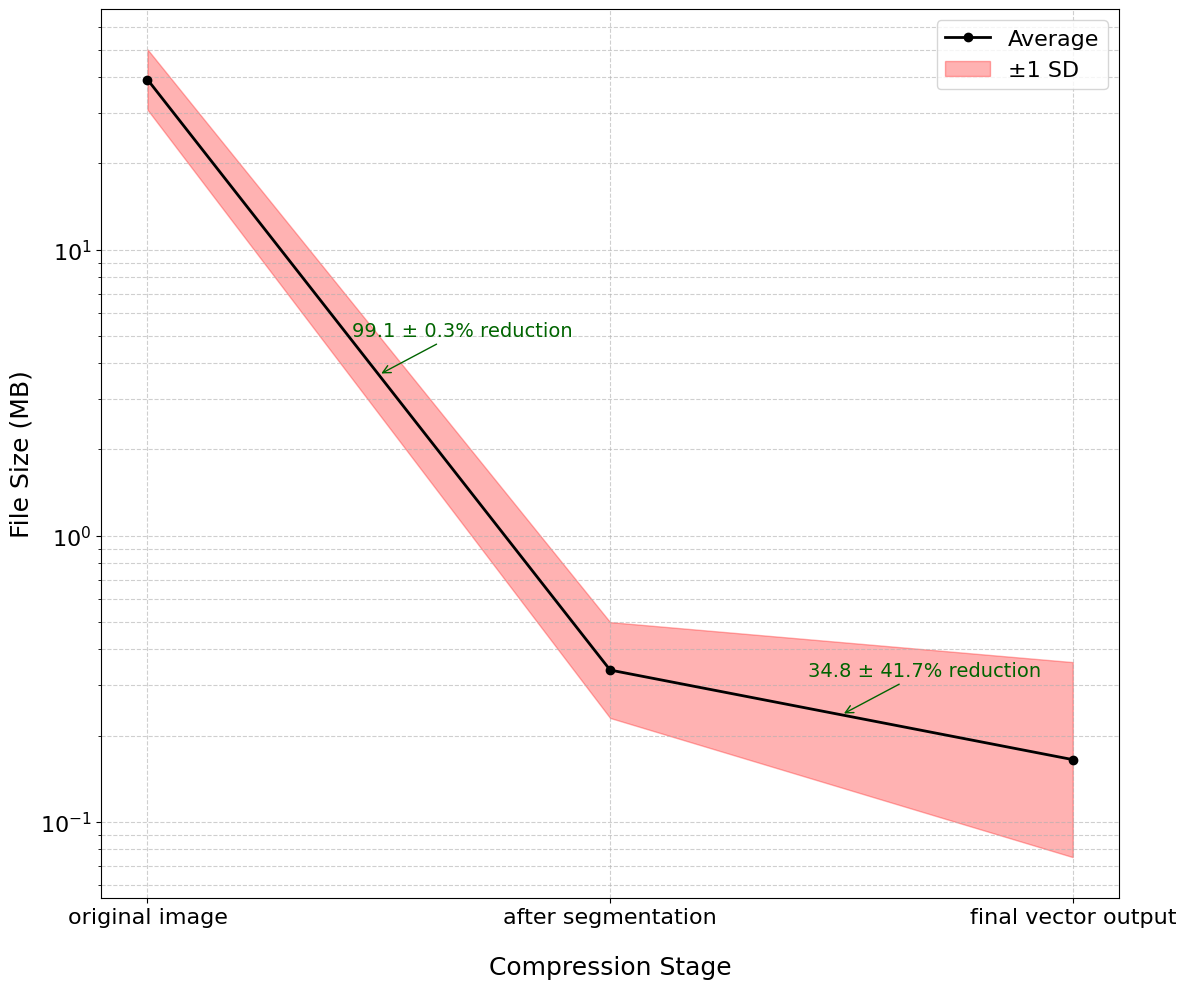

In [64]:
import numpy as np
import matplotlib.pyplot as plt

all_values = []

desired_keys = ["original_image", "threshold_image", "boundaries"]
x_label = [key.replace("_", " ") for key in desired_keys]
for file, data in location_sizes.items():
    values = [data[key]*1e-6 for key in desired_keys if key in data]
    all_values.append(values)

all_values = np.array(all_values)
log_values = np.log(all_values)
mean_log = np.mean(log_values, axis=0)
std_log = np.std(log_values, axis=0)

mean_vals = np.exp(mean_log)
lower = np.exp(mean_log - std_log)
upper = np.exp(mean_log + std_log)


plt.figure(figsize=(12, 10))
plt.rcParams["text.usetex"] = False

colours = plt.get_cmap("tab10")
ax = plt.gca()

# for i, (file, values) in enumerate(zip(location_sizes.keys(), all_values)):
#     location = file.split("_timings",1)[0]
#     plt.plot(values, marker="o", alpha=0.5, label=location, color=colours(i % 10))

x = np.arange(len(x_label))
ax.plot(x, mean_vals, marker = "o", color='black', linewidth=2, label='Average')
ax.fill_between(x, lower, upper,color='red', alpha=0.3, label='±1 SD')

# reductions per sample
reductions_seg = 1 - (all_values[:,1] / all_values[:,0])   # segmentation reduction
reductions_vec = 1 - (all_values[:,2] / all_values[:,1])   # vectorization reduction

# mean and std of reductions
mean_seg = np.mean(reductions_seg)
std_seg  = np.std(reductions_seg)

mean_vec = np.mean(reductions_vec)
std_vec  = np.std(reductions_vec)

reductions = [mean_seg*100,mean_vec*100]
stds = [std_seg*100,std_vec*100]

print(f"Segmentation reduction: {mean_seg*100:.1f}% ± {std_seg*100:.1f}%")
print(f"Vectorization reduction: {mean_vec*100:.1f}% ± {std_vec*100:.1f}%")

for i in range(len(mean_vals) - 1):
    ax.annotate(
        f"{reductions[i]:.1f} ± {stds[i]:.1f}% reduction",
        xy=((x[i] + x[i+1]) / 2, np.sqrt(mean_vals[i] * mean_vals[i+1])),
        xytext=(60, 25),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=14,
        color='darkgreen',
        arrowprops=dict(arrowstyle='->', color='darkgreen')
    )

x_label2 = ["original image", "after segmentation", "final vector output"]
plt.xticks(range(len(x_label)), x_label2, rotation=0,fontsize = 16)
plt.xlabel("Compression Stage",fontsize = 18,labelpad=20)
plt.ylabel("File Size (MB)",fontsize = 18)
plt.yticks(fontsize = 16)
plt.legend(loc = "upper right", fontsize = 16)
plt.yscale("log")

plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [65]:
# reductions per sample
reductions_seg = 1 - (all_values[:,1] / all_values[:,0])   # segmentation reduction
reductions_vec = 1 - (all_values[:,2] / all_values[:,1])   # vectorization reduction

# mean and std of reductions
mean_seg = np.mean(reductions_seg)
std_seg  = np.std(reductions_seg)

mean_vec = np.mean(reductions_vec)
std_vec  = np.std(reductions_vec)

print(f"Segmentation reduction: {mean_seg*100:.1f}% ± {std_seg*100:.1f}%")
print(f"Vectorization reduction: {mean_vec*100:.1f}% ± {std_vec*100:.1f}%")


Segmentation reduction: 99.1% ± 0.3%
Vectorization reduction: 34.8% ± 41.7%
